# 1) Definiera funktioner för att skapa nätet

In [237]:
from dataclasses import dataclass
from typing import Annotated
from numpy import floating, ndarray
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

@dataclass
class TriangulatedGrid:
    points: ndarray
    X: ndarray
    Y: ndarray
    triangulation: tri.Triangulation

    def __init__(
            self,
            resolution: int,
            xlim: tuple[Annotated[float, "min"], Annotated[float, "max"]] = (-1,1),
            ylim: tuple[Annotated[float, "min"], Annotated[float, "max"]] = (-1,1),
        ):
        xmin, xmax = xlim
        ymin, ymax = ylim

        x: ndarray[floating]
        y: ndarray[floating]
        x, y = np.meshgrid(
            np.linspace(xmin, xmax, resolution),
            np.linspace(ymin, ymax, resolution)
        )

        triangles = []
        for j in range(resolution - 1):
            for i in range(resolution - 1):
                # Calculate the indices of the four corners of the square
                p1 = j * resolution + i      # Bottom-left corner
                p2 = p1 + 1                  # Bottom-right corner
                p3 = p1 + resolution         # Top-left corner
                p4 = p3 + 1                  # Top-right corner

                # Define two triangles using the same diagonal
                triangles.append([p1, p2, p4])  # Bottom-right triangle
                triangles.append([p1, p4, p3])  # Top-left triangle

        self.X = x.flatten()
        self.Y = y.flatten()
        self.points = np.vstack([self.X, self.Y]).T
        self.triangulation = tri.Triangulation(self.X, self.Y, triangles)

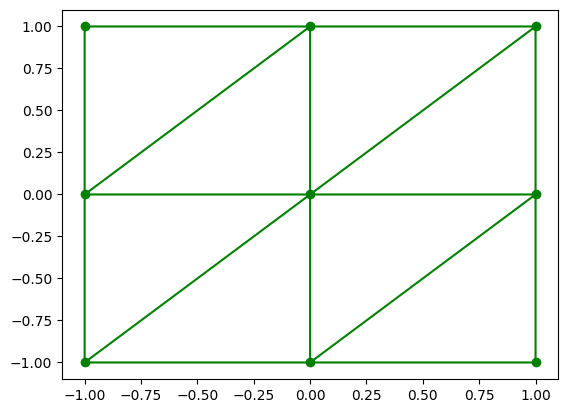

In [238]:
trigrid = TriangulatedGrid(3)
plt.triplot(trigrid.triangulation, 'go-', lw=1.5)

## 1.1) Definera funktioner för att visualisera nätet

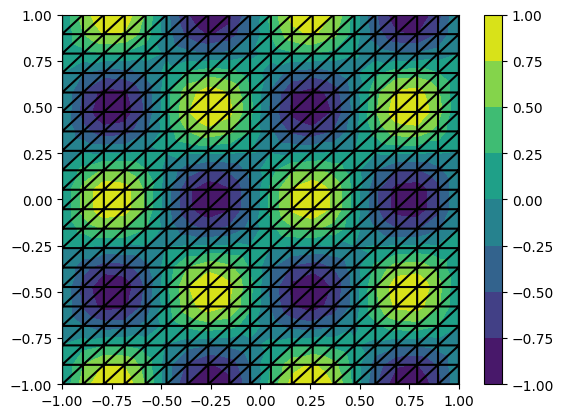

In [239]:
def show_dummy_triplot(trigrid: TriangulatedGrid):
    # Colorize each node according to some dummy function
    values = np.sin(2*np.pi*trigrid.X) * np.cos(2*np.pi*trigrid.Y)

    plt.tricontourf(trigrid.triangulation, values, cmap="viridis")
    plt.triplot(trigrid.triangulation, "k-")
    plt.colorbar()
    plt.show()

show_dummy_triplot(TriangulatedGrid(20))

# 3) Styvhetsmatrisen

## 3.1) Delar för att sätta upp styvhetsmatrisen
Innan vi börjar med styvhetsatrisen kommer här lite definitioner vi kommer behöva

> RE: Area av en triangel
>
> Av vektorer: <br>
> $\frac{1}{2} \left\lvert \det{\begin{bmatrix}\vec{AB} & \vec{AC} \end{bmatrix}} \right\rvert$
>
> $\begin{CD}
A @>{\vec{AB}}>> B \\
@V{\vec{AC}}VV \\
C
\end{CD}$
>
> Alternativt: <br>
> $\frac{1}{2} \lvert x_1(y_2-y_3) + x_2(y_3-y_1) + x_3(y_1-y_2) \rvert$

In [240]:
def triangle_area_from_2dvertex_positions(A: ndarray, B: ndarray, C: ndarray):
    AB = B-A
    AC = C-A
    return 0.5 * np.abs(np.linalg.det(np.hstack([AB, AC])))

> RE: Kovertering mellan matrismultiplikation och summor
>
> $A \in \mathbb{R}^{m \times n}$, $B \in \mathbb{R}^{n \times w}$
>
> $(A \cdot B)_i = \displaystyle\sum_{k\in\mathbb{K}} A_{ik} \cdot B_{k}$

# 3.2) Undersök styhetsmatrisen

> RE: Styvhetsmatris defintion i 2d
>
> $\displaystyle\sum_{i=1}^N U_i
\underbrace{\iint_D \alpha \nabla\phi_i \cdot \nabla\phi_j dA}_{\large a_{ji}}
= \underbrace{\iint_D f\phi_jdA}_{\large b_{j}}
,\quad j=1,\cdots,N$
>
> Altså: $AU = b$

> ⚠️ $\varepsilon / \alpha$  är 1 enl uppgift, så den tas bort

$a_{ji} = \displaystyle\iint_D \alpha \nabla\phi_i \cdot \nabla\phi_j dA$

$b_{j} = \iint_D f\phi_jdA$

Låt och diskretisera problemet:

$a_{ji} = \displaystyle\sum_{T \in \{T_j\}_{j=1}^M} \displaystyle\iint_T \alpha \nabla\phi_i \nabla\phi_i \cdot \nabla\phi_j dA$

$b_{j} = \displaystyle\sum_{T \in \{T_j\}_{j=1}^M} \iint_T f\phi_j dA$

Där $\{T_j\}_{j=1}^M$ är trianguliseringen

> RE:
>
> $\phi_i(P_j) = \begin{cases}
   1 &\text{om } i = j \\
   0 &\text{om } i \ne j
\end{cases}$
>
> Där $P$ är nätets punkter

Inom en triangel $T$ beter sig basfunktionerna så att $\phi_1$ är $1$ i hörn 1 och $0$ i alla andra. Motsvarande stämmer för $\phi_2$ och $\phi_3$

Följande figur visar var i de två olika riktningar av trianglar i nätet  och var $\phi_1, \phi_2, \phi_3$ befinner sig i respektive.
```
┌──────────────────┐
│ (+y)             │
│   |  2-3    3    │
│   |  |/    /|    │
│   |  1    1-2    │
│    -------- (+x) │
└──────────────────┘
```
Vi namnger dess två olika orientationer som olika trianglar:
V-trianglar och H-trianglar *(vänster respektive höger i bilden)*




Om vi vill ha en kontinuerlig definition av basfunktionerna har vi:

$\begin{matrix}
\phi_1(x,y) = a_1 + b_1x + c_1y\\
\phi_2(x,y) = a_2 + b_2x + c_2y\\
\phi_3(x,y) = a_3 + b_3x + c_3y\\
\end{matrix} \iff \begin{bmatrix}
\phi_1(x,y) \\
\phi_2(x,y) \\
\phi_3(x,y) \\
\end{bmatrix} = \begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix}\begin{bmatrix}
1\\x\\y\\
\end{bmatrix}$

> ⚠️ Åt minstånde innanför triangeln, utanför trianglen ska $\phi$ vara 0, men då saknas en smidig matematisk definition

$\phi_1(x_1,y_1)=1$, $\phi_1(x_2,y_2)=0$, $\phi_1(x_3,y_3)=0$<br>
$\phi_2(x_1,y_1)=0$, $\phi_2(x_2,y_2)=1$, $\phi_2(x_3,y_3)=0$<br>
$\phi_3(x_1,y_1)=0$, $\phi_3(x_2,y_2)=0$, $\phi_3(x_3,y_3)=1$<br>

### H-trianglar:

$\phi_1(x_1,y_1)=1$, $\phi_1(x_1+h,y_1)=0$, $\phi_1(x_1+h,y_1+h)=0$<br>
$\phi_2(x_1,y_1)=0$, $\phi_2(x_1+h,y_1)=1$, $\phi_2(x_1+h,y_1+h)=0$<br>
$\phi_3(x_1,y_1)=0$, $\phi_3(x_1+h,y_1)=0$, $\phi_3(x_1+h,y_1+h)=1$<br>

där $h$ är gridstoleken i nätet

Skriv om som matris:

$\begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix} \begin{bmatrix}
  1 &   1 &   1   \\
x_1 & x_1+h & x_1+h \\
y_1 & y_1   & y_1+h \\
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix}$

$A_HB_H = I \iff A_H = B_H^{-1}$

*Lösning mha. Wolfram alpha*

$A_H = \frac{1}{h} \begin{bmatrix}
h+x_1   & -1 & 0 \\
y_1-x_1 &  1 & -1 \\
-y_1    &  0 & 1 \\
\end{bmatrix}$

### V-trianglar:

$\begin{bmatrix}
a_1 & b_1 & c_1 \\
a_2 & b_2 & c_2 \\
a_3 & b_3 & c_3 \\
\end{bmatrix} \begin{bmatrix}
  1 &   1   &   1   \\
x_1 & x_1   & x_1+h \\
y_1 & y_1+h & y_1+h \\
\end{bmatrix} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{bmatrix}$

$A_V = \frac{1}{h} \begin{bmatrix}
h+y_1   &  0 & -1 \\
x_1-y_1 & -1 &  1 \\
-x_1    &  1 &  0 \\
\end{bmatrix}$

Visualisering av $x_1 y_1$(röd) $x_2 y_2$(blå) $x_3 y_3$(grön) samt deras korreponderande $\phi$ funktioner
![alt text](images/2024-08-1919-30-15-ezgif.com-video-to-gif-converter.gif)


# 3.3) Räkna ut $a_{ij}$

Låt os betrakta en triangel och

$\displaystyle\iint_T \alpha \nabla\phi_i \cdot \nabla\phi_j dA$

> RE
$\begin{bmatrix}
\phi_1(x,y) \\
\phi_2(x,y) \\
\phi_3(x,y) \\
\end{bmatrix} = A \begin{bmatrix}
1\\x\\y\\
\end{bmatrix}
$

H-trianglar

$\nabla\phi_1 \cdot \nabla\phi_2 = \begin{bmatrix}b_1 \\ c_1\end{bmatrix} \cdot \begin{bmatrix}b_2 \\ c_2\end{bmatrix} = \frac{1}{h^2}(-1\cdot 1 + 0\cdot -1) = \frac{-1}{h^2}$

$\nabla\phi_1 \cdot \nabla\phi_3 = \begin{bmatrix}b_1 \\ c_1\end{bmatrix} \cdot \begin{bmatrix}b_3 \\ c_3\end{bmatrix} = \frac{1}{h^2}(-1\cdot 0 + 0\cdot 1) = \frac{0}{h^2}$

$\nabla\phi_2 \cdot \nabla\phi_3 = \begin{bmatrix}b_2 \\ c_2\end{bmatrix} \cdot \begin{bmatrix}b_3 \\ c_3\end{bmatrix} = \frac{1}{h^2}(1 \cdot 0 + -1\cdot 1) = \frac{-1}{h^2}$
<br>

V-trianglar

$\nabla\phi_1 \cdot \nabla\phi_2 = \begin{bmatrix}b_1 \\ c_1\end{bmatrix} \cdot \begin{bmatrix}b_2 \\ c_2\end{bmatrix} = \frac{1}{h^2}(0\cdot -1 + -1\cdot 1) = \frac{-1}{h^2}$

$\nabla\phi_1 \cdot \nabla\phi_3 = \begin{bmatrix}b_1 \\ c_1\end{bmatrix} \cdot \begin{bmatrix}b_3 \\ c_3\end{bmatrix} = \frac{1}{h^2}(0\cdot 1 + -1\cdot 0) = \frac{0}{h^2}$

$\nabla\phi_2 \cdot \nabla\phi_3 = \begin{bmatrix}b_2 \\ c_2\end{bmatrix} \cdot \begin{bmatrix}b_3 \\ c_3\end{bmatrix} = \frac{1}{h^2}(-1 \cdot 1 + 1\cdot 0) = \frac{-1}{h^2}$

Altså:
$\displaystyle\iint_T \alpha \nabla\phi_1 \cdot \nabla\phi_2 dA = -\frac{\alpha}{h^2} \displaystyle\iint_T dA$

Integral över ytan oberoende av funktion = arean av ytan = ytan av triangel = $h^2/2$

Sammanfattningsvis får vi följande för både V och H trianglar.

$\displaystyle\iint_T \alpha \nabla\phi_1 \cdot \nabla\phi_2 dA = -\frac{\alpha}{2}$

$\displaystyle\iint_T \alpha \nabla\phi_1 \cdot \nabla\phi_3 dA = 0$

$\displaystyle\iint_T \alpha \nabla\phi_2 \cdot \nabla\phi_3 dA = -\frac{\alpha}{2}$

# 3.4) Räkna ut $b_{j}$

Låt os betrakta en triangel och

$\displaystyle\iint_T f\phi_j dA$

Denna formel kan inte smidigt förenklas så vi gör en aproxmination mha diskretisering.

$≈ \displaystyle\sum_{(x,y)\in \{C\}_{i=1}^3} f(x,y) \phi_j \Delta A$

Där $\{C\}_{i=1}^3$ de tre hörnen av triangeln

$\Delta A$ = en tredjedel av hela triangelarean

# 4 Algoritm


> Vi itererar igenom alla trianglar i nätet, från varje triangel tar vi ut noder som utgör hörnen av triangler
> (Mer specifikt så läser vi vilka index hörnens har i den endimensionella array vi sparat nätets noder i)
>
>>    Vi räknar ut varjes triangels area (även om det råkar vara samma för
>>        alla med våran triangulisering)
>>
>>    Sen gör vi något lite knepigt, kom ihåg att
>>
>> $a_{ji} = \displaystyle\sum_{T \in \{T_j\}_{j=1}^M} \displaystyle\iint_T \alpha \nabla\phi_i \nabla\phi_i \cdot \nabla\phi_j dA$<br>
>> $b_{j} = \displaystyle\sum_{T \in \{T_j\}_{j=1}^M} \iint_T f\phi_j dA$
>>
>> Istället för att iterara genom varje $a_{ji}$ och sen för varje triangel i nätet aproximera integralen kan vi spara mycket arbete genom itera genom varje triangel och endast addera effekterna på de $a_{ji}$ som påverkas av triangeln.
>>
>> RE: nästan alla $a_{ji}$ är noll då noder som inte har en kant imellan får integralerna lika med 0
>>
>>

In [241]:
from typing import Callable, Generator
from numpy import ndarray

@dataclass
class TriangleCorner:
    pos: ndarray[floating] # [x,y] position för hörnet
    local_corner_idx: int # hörnpunktens hörnindex för den triangeln den är del av
    glob_point_idx:   int # hörnpunktens index i triangulaiseringens punktarray

@dataclass
class Triangle:
    corners: tuple[TriangleCorner, TriangleCorner, TriangleCorner]
    glob_triangle_idx: int # triangelns index i triangulaiseringens triangelarray

def extract_triangles(trigrid: TriangulatedGrid) -> Generator[Triangle, None, None]:
    for glob_triangle_idx, glob_point_idxs in enumerate(trigrid.triangulation.triangles):
        triangle_corners = [None,None,None]
        for local_corner_idx, glob_point_idx in enumerate(glob_point_idxs):
            triangle_corners[local_corner_idx] = TriangleCorner(
                pos=trigrid.points[glob_point_idx, :, np.newaxis], # Extrahera hela rad glob_point_idx som en kolummatris
                local_corner_idx=local_corner_idx,
                glob_point_idx=glob_point_idx,
            )
        yield Triangle(
            glob_triangle_idx=glob_triangle_idx,
            corners=tuple(triangle_corners),
        )

In [242]:

@dataclass
class StiffnessMatrixSolve:
    A: ndarray
    b: ndarray

    def __init__(
            self,
            trigrid: TriangulatedGrid,
            f: Callable[[float, float], float]
        ):
        n_points = len(trigrid.points)
        A = np.zeros((n_points, n_points))
        b = np.zeros((n_points, 1))

        for triangle in extract_triangles(trigrid):

            area = triangle_area_from_2dvertex_positions(
                A=triangle.corners[0].pos,
                B=triangle.corners[1].pos,
                C=triangle.corners[2].pos,
            )

            # b
            # Triangeln har 3 hörn,
            #   Varje hörn påverkar dess korresponerande b värde
            for tc in triangle.corners:
                contribution = f(*tc.pos) * area / 3
                b[tc.glob_point_idx] += contribution

            # A
            # Triangeln har 3*3 par av hörn
            #   Varje par påverkar dess korresponerande a_{ji}
            #   (där ji är hörnens index i "points")
            # tca = triangle corner a
            for tca in triangle.corners:
                tidx_a = tca.local_corner_idx

                # x,y position av angränsade hörn
                pos_clockwise_from_tca = triangle.corners[(tidx_a + 1) % 3].pos
                pos_anticwise_from_tca = triangle.corners[(tidx_a + 2) % 3].pos

                for tcb in triangle.corners:
                    tidx_b = tcb.local_corner_idx
                    pos_clockwise_from_tcb = triangle.corners[(tidx_b + 1) % 3].pos
                    pos_anticwise_from_tcb = triangle.corners[(tidx_b + 2) % 3].pos

                    # numpys vanliga dotproduct funktion tar bara emot radvektorer (dumt...)
                    contribution = np.vdot(
                        (pos_clockwise_from_tca - pos_anticwise_from_tca),
                        (pos_clockwise_from_tcb - pos_anticwise_from_tcb)
                    ) * area / (4 * area)** 2

                    A[tca.glob_point_idx, tcb.glob_point_idx] += contribution

        # Applicera Dirilectvilkor
        for pidx, (x, y) in enumerate(trigrid.points):
            if x == -1 or x == 1 or y == -1 or y == 1:
                # nollställa alla A som beror på koordinaten
                A[pidx, :] = 0
                A[:, pidx] = 0
                b[pidx] = 0

                # this does not make sense?
                A[pidx, pidx] = 1

        self.A = A
        self.b = b


In [243]:
from matplotlib.pyplot import spy
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

def solve_u_and_visualize(
        trigrid: TriangulatedGrid,
        solve: StiffnessMatrixSolve
        ):
    # Colorize each node according to some dummy function
    A = csc_matrix(solve.A)
    b = solve.b
    spy(A)
    #plt.imshow(solve.A)
    #plt.colorbar()
    plt.show()

    U = spsolve(A, b)
    #print(f"{A.shape=} {b.shape=} {trigrid.points.shape=}")
    plt.tricontourf(trigrid.triangulation, U, cmap="viridis")
    plt.triplot(trigrid.triangulation, "k-")
    plt.colorbar()
    plt.show()



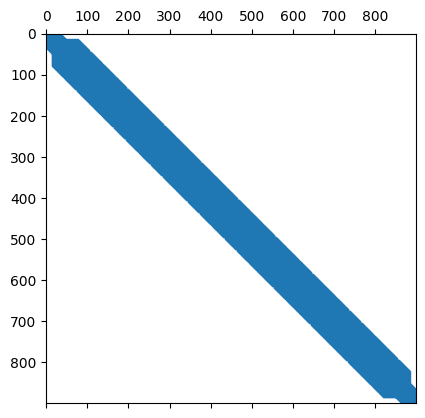

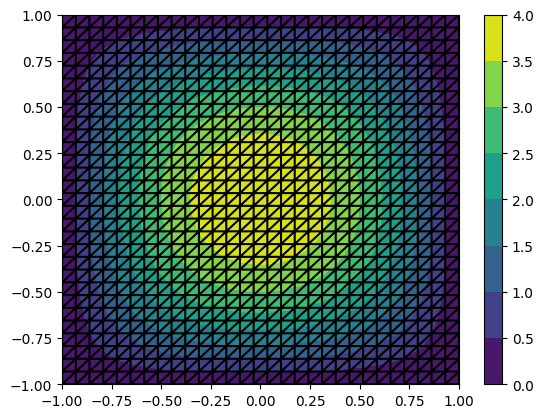

In [244]:
def f(x: float, y: float) -> float:
    return 2*(2-(x**2)-(y**2))-2*x*y*(x**2-y**2)

trigrid = TriangulatedGrid(30)
solve_u_and_visualize(trigrid, StiffnessMatrixSolve(trigrid, f))